# Report Challenge IMA 205 - Cardiac pathology prediction - Elouan GARDES

## 1 - General considerations

### 1.1 - Structure

This report will cover the methodology I followed during the challenge, as well as the results I obtained. 

It will contain only the most important parts of the code for demonstration purposes. The whole code will be uploaded in a zip format, and is also available directly for ready-to-run execution on my github: https://github.com/El-One1/Code-report-IMA205

To run this report, only the import cell here after is necessary. Python 3.10.9 and subsequent library versions were used. "functions.py" is a utils file containing functions used across the project. All other libraries are standard.

Some cells are not meant to run (especially in the Deep Learning section) and will crash, they are presented only for readibility and to illustrate. The corresponding code is able to run on the dedicated notebooks (see github).

All the github code runs, however some code may not be updated (e.g some raw functions which were then put in functions.py are still in the notebook) as they contain slight variations and were discarded as promising options.

The kaggle accuracy are in format (public score, private score).

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

import torchio as tio
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

from sklearn.ensemble import VotingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from seaborn import heatmap

from functions import *

### 1.2 - Approach 

In practice, the approach followed was the following:

- Discovering and understanding the data provided,

- First trials with very simple approach and little features (no preprocessing),

- Preprocessing (left ventricule extraction),

- Trials with simple features (raw volumic informations),

- Introduction of more features (ejection fraction, ratios),

- Trials with Deep Learning,

- Extraction of more complex features (thicknesses),

- Model exploration and fine tuning.

I spent quite some time figuring out which features to use, to differenciate what pathologies, etc.
I found the four wikipedia pages (in english) for the four pathologies to be the most useful sources. I used in particular the physiological symptoms listed for each pathology as proxies to find the features that would best embody them. 

I can already say that, if I had to do it over again, I would spend much more time from the beginning on feature understanding and extraction. I spent too much time way too early on trying different models, hoping for jumps in performance from that when I really now see how features were everything here and how little difference models actually made on accuracy (cf my two best results at the end!).

Let us dive in!

## 2 - Discovering the data, first trials

### 2-1 Discovering the data

I used the following data structure during all the challenge:

Spacing: (1.3671900033950806, 1.3671900033950806, 10.0),
Raw left-ventricule volume: 6202


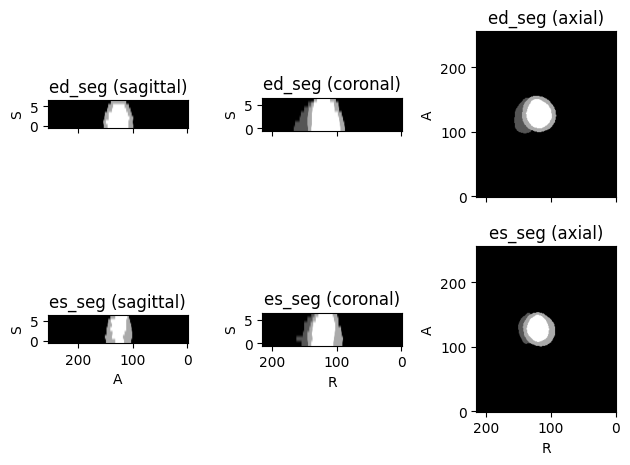

In [36]:
subject = tio.Subject(
    ed_seg = tio.ScalarImage('Train/053/053_ED_seg.nii'),
    es_seg = tio.ScalarImage('Train/053/053_ES_seg.nii'),
)

spacing_info = subject.ed_seg.spacing
raw_volume_LV_es = (subject.es_seg.data == 3).sum().item()

print("Spacing: {},\nRaw left-ventricule volume: {}".format(spacing_info, raw_volume_LV_es))
subject.plot()

Spacing yielded information on the real volume of structures, as images were not all obtained at the same zoom level. 

Volumes were computed as the sum of all voxels of the structure. It could later be multiplied by spacing.
I ended up not doing that for volumes as I normalized them (i.e took zoom information in consideration by introducing background volume, which yielded better results on val sets), but I did use spacing for thicknesses later on.

Torchio subject objects were really usefull to plot everything at once, but also to have all relevant info for a given subject in one place.

### 2-2 First trials

Ready-to-run code: Bayesian models -> bayesian_2D.

My very first approach was a Naïve Bayesian Model (GNB) trained only on two features: subject's height and weight. 
I built that first model by hand (I actually did not know of the sklearn implementation at the time).

Only data from the MetaData file was thus used.

This method yielded a 35% accuracy on the training set, and a whooping (46%, 28%) on Kaggle.

My motivation to only try that, apart from willing to test out of sheer excitment, was to see whether or not height and weight had a promising predictive power. I wanted to know if I should keep then later on.

Here is the confusion matrix I got:

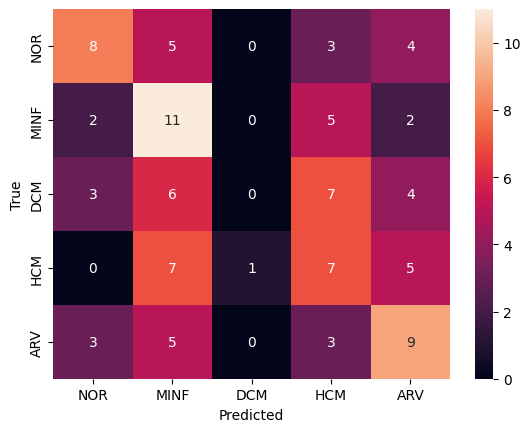

Eventhough accuracy is better than random (0.2), the matrix clearly shows the limits of these two features: they are irrelevant for DCM prediction, as well as for HCM. 

In the first case, DCM is never prefered over the other classes, and in the second case, HCM is nearly predicted at random.

I kept using height and weight for a while after this because of the kaggle private accuracy and the fact that I was at the time too dumb to use a validation set, but I later on discarded them and prefered other feature less prone to overfitting.

You may see on github that I also tried GNB with more features (volumic information) but my out-of-hand-built method was overfitting and pretty poorly optimized. I did not submit from those files.

## 3 - Preprocessing

It was high time I added features. But, to do so effectively, I needed to preprocess the data to extract the left ventricule for the test subjects.

At first, very scared, I considered using a pretrained segmentation model fine-tuned on Left Ventricule (LV) extraction from the 100-samples training set. 

But I then looked more closely at the data and realized that, along the axial axis, the LV was always inside the myocardium. 

This made the preprocessing very easy: for each slice along the axial axis, just fill the area inside the myocardium with a "3" label (for lv), on all test subjects. No further preprocessing was needed. 

I did test the method on some training samples and obtained perfect volumes everytime.

Here's the code (available in the main "functions.py" file outside any folder):

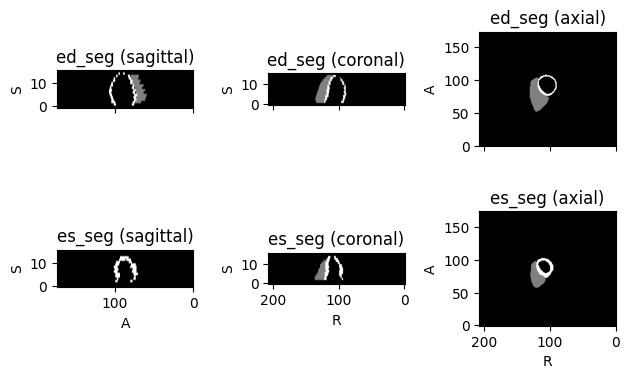

In [20]:
test_subject = tio.Subject(
            ed_seg=tio.ScalarImage('Test/10' + str(2) + '/10' + str(2) + '_ED_seg.nii'),
            es_seg = tio.ScalarImage('Test/10' + str(2) + '/10' + str(2) + '_ES_seg.nii'),
        )
test_subject.plot()

Text(0.5, 1.0, 'Left ventricule segmentation')

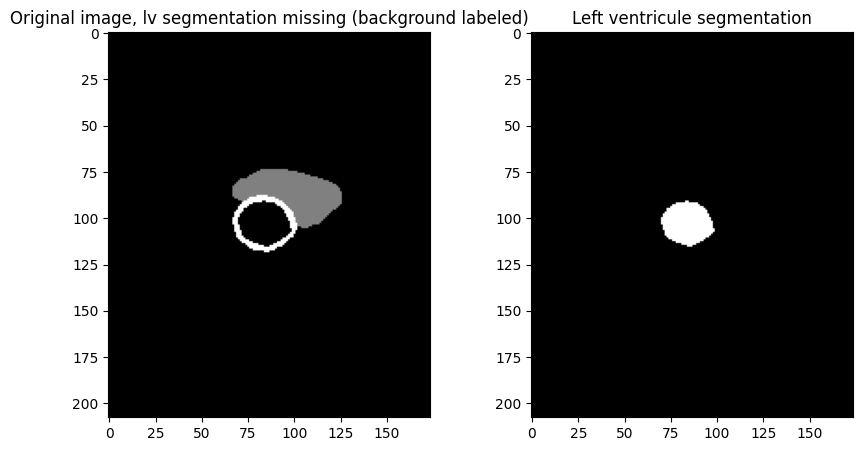

In [35]:
from scipy.ndimage import binary_fill_holes

def lv_volume(binary_image):
    ### INPUT : the 3D image where we only keep the myocardium
    ### OUTPUT : the 3D image where we only have the left ventricule
    mask = np.zeros(binary_image.shape)

    for i in range (binary_image.shape[2]): # along axial axis
        mask[:,:,i] = binary_fill_holes(binary_image[:,:,i]).astype(int)
        mask[:,:,i] -= binary_image[:,:,i] # removing myocardium to only have ventricule
        
    return mask

ed_seg = test_subject.ed_seg.data.numpy()[0]  #taking data, converting from torch to numpy, flattening first dimension (see torchio doc - 4D base object)
ed_seg_myo = (ed_seg == 2)
ed_seg_lv = lv_volume(ed_seg_myo)


## Plotting only 5th slice, feel free to change to any other slice
ax, fig = plt.subplots(1,2, figsize = (10,5))
fig[0].imshow(test_subject.ed_seg.data[0,:,:,5], cmap = 'gray')
fig[0].set_title('Original image, lv segmentation missing (background labeled)')
fig[1].imshow(ed_seg_lv[:,:,5], cmap = 'gray')
fig[1].set_title('Left ventricule segmentation')

You may notice the testFilled folder on github, I made it using a method that created some weird results so I discarded it. I kept it to not change all imports but I only used the here-given method to find volumes of the LV.

## 4 - Trials with simple features

Having segmented the LV, I could now use all three volumes (LV, myocardium (M) and Right Ventricule (RV)) to predict.

Having two volumes for each structure (at times ED and ES), this made 6 raw volumic features in total, to which I added the height and weight of the subject.

I also used background volume at that time to take into account zoom levels, as I did not normalize volumes at the time. To not modify the flow of my challenge the matrices here-after use that method, but I later on normalized volumes and tested my old models, which increased accuracy on the val sets by one or two samples.

Here is the code used to build the features vector (e.g given for the test set, similar code for training set):

In [ ]:
## DO NOT EXECUTE ## ## THIS CODE CAN BE EXECUTED ON ALL NOTEBOOKS FROM ENSEMBLE METHODS ON GITHUB ##

metaData = pd.read_csv('../metaDataTest.csv')
metaDataClean = metaData.iloc
features_metadata = select_row_x_and_y_from_table(metaDataClean, 2, 3)

test_features = np.zeros((50,8))
test_features[:,:2] = features_metadata # getting height, weight

test_subject_list = load_test_dataset() ## see functions.py

volumes_1_ed = []
volumes_2_ed = []
volumes_3_ed = []

volumes_1_es = []
volumes_2_es = []
volumes_3_es = []

   
for i in range(0, 50):

    subject_ed = test_subject_list[i].ed_seg.data.numpy()[0]
    ed_view = test_subject_list[i].ed_seg

    ## see functions.py for get_volume: it just counts voxels from a given label             # use preprocessing function for LV
    sum_volumes = get_volume(ed_view, 0) + get_volume(ed_view, 1) + get_volume(ed_view, 2) + int((lv_volume(subject_ed == 2)).sum())
    volumes_1_ed.append(get_volume(ed_view, 1)/sum_volumes)
    volumes_2_ed.append(get_volume(ed_view, 2)/sum_volumes)
    volumes_3_ed.append(int((lv_volume(subject_ed == 2)).sum())/sum_volumes)

    subject_es = test_subject_list[i].es_seg.data.numpy()[0]
    es_view = test_subject_list[i].es_seg

    sum_volumes = get_volume(es_view, 0) + get_volume(es_view, 1) + get_volume(es_view, 2) + int((lv_volume(subject_es == 2)).sum())
    volumes_1_es.append(get_volume(es_view, 1)/sum_volumes)
    volumes_2_es.append(get_volume(es_view, 2)/sum_volumes)
    volumes_3_es.append(int((lv_volume(subject_es == 2)).sum())/sum_volumes)

for i, new_col in enumerate([volumes_1_ed[:], volumes_2_ed[:], volumes_3_ed[:], volumes_1_es[:], volumes_2_es[:], volumes_3_es[:]]):
    test_features[:,i+2] = new_col

A thing I would do differently is that I would have put all features possible in a pandas dataframe (I later did it for thicknesses) and then use the dataframe to build the features vectors. It would have allowed me to not have those big cells in every notebook and to gain a bit of time (eventhough it is rather fast to compute - 5 seconds tops).

Having these features vectors, I was then able to test any model I wanted on them. Before training, I shuffled the data and split it into a training and validation set of 75/25. I finally fixed stratify=classes to get exactly 5 examples from each class in the validation set.

Things I tried on those features:

- Decision Trees, 

- AdaBoost,

- Random Forests,

- SVM,

- XGBoost (gradient boosting),

- Two-layers fully connected Multi Layers Perceptron (MLP) (with batchnorm/dropout).

For each, I spent quite some time fine-tuning the hyperparameters, partly using cross-validation and grid-search.

As mentioned earlier, the actual performance difference came not from the model but rather from the features I added later on.

This is mainly because of the dataset used at this point: 10 features with 100 examples is pretty flexible and falls into the capibilites of all said models. There was not much change to expect to begin with from using a model instead of another (in terms of accuracy)

Still, for the sake of discussion, here are things which changed:

- Ensemble methods were not dependant of any scaling (as expected), whereas SVM, MLP were a lot. XGBoost also did show some sensitivity to scaling, though not so much. Anytime I needed to scale data, I used StandardScaler from sklearn. (see, for instance, SVM notebook).

- Random forest showed a lot of robustness, meaning that on different random inits, its validation accuracy was much more stable than AdaBoost for example. 

- Eventhough the accuracies of these models were pretty similar, the confusion matrices were not. The models did not fit in the same way at all, some of them being much better at distinguishing from two pathologies than others.

That last point is the most important and stuck with me for the rest of the work. This could lead to many follow-ups: voting classifiers (trying to combine the strenghts of each model), two-stage classifiers (a first general one, then an expert to just distinguish between two categories), this kind of things. I will develop that later on.

To illustrate this discussion, here are confusion matrices obtained from AdaBoost, SVM and Random Forest for the same features (runnable in dedicated notebooks - put the same feature first as I added new ones since).

Random state was fixed to compare the matrices properly, it was fixed to a state which I found significative in the sense that models produced the matrices here-after regularly (because of course they are sample-dependant).

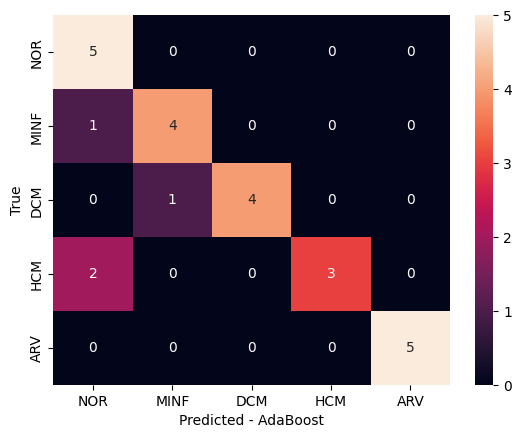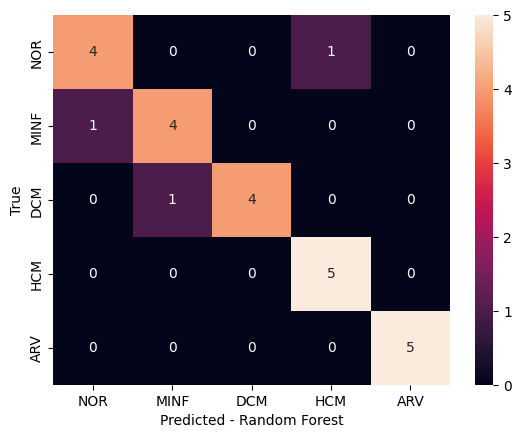 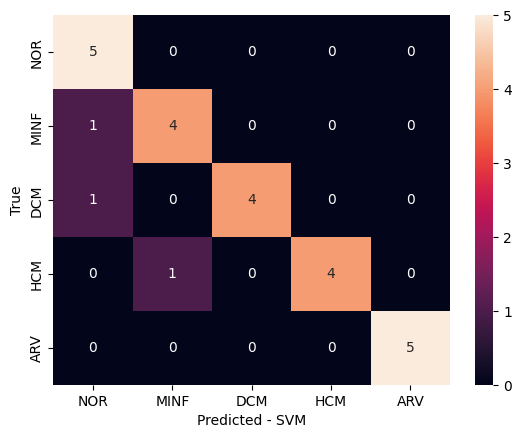

I want to point out two things from these matrices which will come back:

- The AdaBoost makes two confusions by predicting NOR instead of HCM. 
This comes back very often in my best models later on, and I suspect that I still have mistakes from that confusion on my best submissions. 

I was never able to produce a model capable of never doing one mistake from time to time on that confusion on val sets.

At this point, this is to be expected:
The best differenciator for NOR-HCM is the thickness (ought to be no more than 12mm in diastole for NOR, and more than 15mm in diastole [1]) of the left-ventricule which is not yet used.

- There are confusions between DCM and MINF. Once again, this will come back later-on and be partly solved by introducing thicknesses.

There is one NOR-MINF confusion which happens quite often on these matrices but it is seed-dependant from what I have seen. That confusion does appear sometimes, and is solvable by introducing ejection fractions and ratios. The LV ejection fraction in particular was used as a perfect differenciator along with volumes for that confusion.
This is because MINF is usually caracterized by a high blood pressure leading to different ejection fractions as the flow is perturbed during contraction of the heart.

## 5 - Introducing more features

I felt stuck on my accuracy levels using these simple features, and beside I did little research at that point.

My kaggle accuracy was (85.7%, 60%) and because the accuracy I could see was so low (despite my val accuracy), I had little confidence in my models at that point as I did not understand the link between my val and the overall test accuracy I would have (I thought of the 60% shown on Kaggle as more or less my future test accuracy, when it was pretty not reliable in reality).

Diving into the research papers provided, I noticed that all of them used ratios and ejection fractions. 
By checking back on the wikipedia pages of the pathologies, I figured out why as these sicknesses are all caracterized by a perturbation of the blood flow in the heart. 

We already mentioned MINF which mostly affect blood pressure, there is also ARV which is characterized by fibrosis leading to a very particular dilation of the right ventricule (note - ARV is so particular that only using RV volumes is enough to detect it, there are never confusion with that pathology which is spectacular).


Here is the implementation for these new features:

In [ ]:
## Do not execute me ##

ejection_fraction_right = (volumes_1_ed - volumes_1_es) / volumes_1_ed
ejection_fraction_left = (volumes_3_ed - volumes_3_es) / volumes_3_ed

ratioRL_ed = volumes_3_ed / volumes_1_ed
ratioRL_es = volumes_3_es / volumes_1_es

ratioML_ed = volumes_2_ed / volumes_1_ed
ratioML_es = volumes_2_es / volumes_1_es

At that point, I noticed no improvement (and even sometimes a decrease) in my val accuracy when introducing height and weight. 

Eventhough these features have some predictive power, their information seems entierely contained in the volumic information and thus they only lead to overfitting.

This led me, at that time, to use 12 features to predict: 6 normalized volumes (ex: volume of LV / sum of volumes), 4 ratios, and 2 ejection fractions.

I tried again the models mentioned before on these features. I will not comment again all of them, I will take the random forest and SVM.

I got the most reliable high accuracy using a random forest classifier composed of 1000 trees, leaving all other parameters to default (I never increased accuracy by tweaking them).
Accuracy on my 25-samples validation set ranged between 88% (1 time out of 10) to 100% (2 times out of 10).

Out of the SVM, accuracy ranged from 88% to 96% on my validation set. A Radial basis function (rbf) kernel was used. Once again, hyperparameters did not influence much and I found the best results with rbf, which is very smooth.

The most common accuracy was 92% of my validation set with random forest, and 88% with SVM. Here are the corresponding confusion matrices:

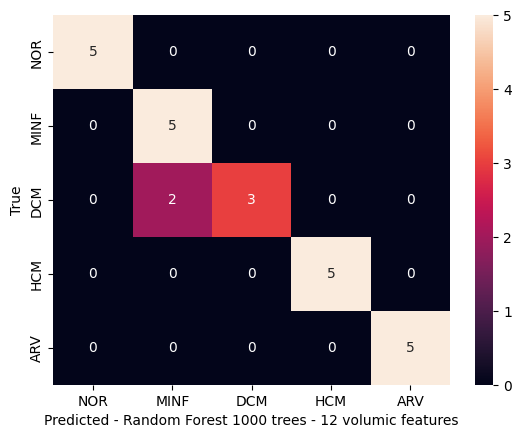 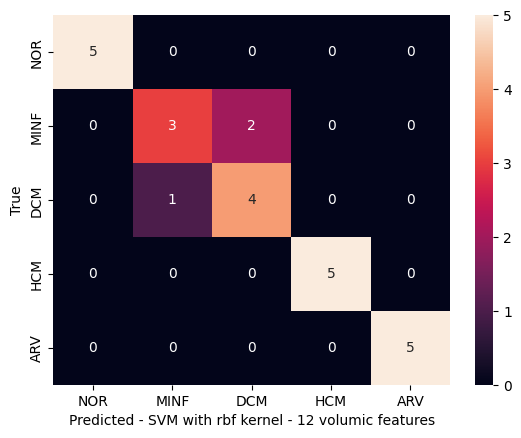

Accuracy on kaggle using the random forest was (88.5%, 86.6%).

- Looking at the confusion matrices both from SVM and RF, it is clear that with our new features, we have improved accuracy at the cost of poorer (or at least no better) distinctions between DCM and MINF. 


- There is quite the drop between my validation accuracy and the Kaggle score. Running the RF multiple times on different validation sets, I realized that I often find myself making an other confusion between NOR (prediction) and HCM (target).

I suspect that this confusion leads to the drop observed on Kaggle since I did not spot any other kind of confusion running the algorithm multiple times.

- For the DCM/MINF confusion: it is in fact not surprising to confuse our model more by introducing our new features - especially ejection fractions - for that distinction. According to [1], both MINF and DCM are partly caracterized by an ejection fraction of less than 40%, which means that our added features have 0 predictive power for that distinction and basically lead the model to guess at random on their basis.

- For the NOR/HCM confusion: Again, both pathologies are partly caracterized by high ejection fraction (above 50% for NOR, above 55% for HCM ([1])). Since they do not have exactly the same clinical threshold, it does not mess up the model as much as for the DCM/MINF confusion, but it still leads our model to make some mistakes.

## 6 - Trials with deep learning

### 6.1 - Multi-layer perceptron

I mentioned using a MLP before, I kept experimenting with it but it did not yield better accuracies or particular matrices compared with my random forests and svms. 

I had severe overfitting with MLPs, and I only managed to get a validation accuracy just below RF 1000 trees using dropouts and batchnorm on a two hidden layers MLP.

Updating the model with the right features after the end of the kaggle challenge (as I realized I had not tested it fully), I managed to up to a (94%, 80%) accuracy with the following architecture on the 12 features already discussed:

In [ ]:
## Do not run me :( ## ## pytorch implementation ##

## codes runs in deeplearning/linear_model_base.ipynb ##

class LinearModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear1 = nn.Linear(12, 100)
        self.linear2 = nn.Linear(100, 100)
        self.linear3 = nn.Linear(100, 5)

        self.dropout = nn.Dropout(0.2)
        self.norm1 = nn.BatchNorm1d(100)


    def forward(self, xb):
        out = self.linear1(xb)        
        out = F.leaky_relu(out)
        out = self.dropout(out)
        out = self.norm1(out)
        out = self.linear2(out)
        out = F.leaky_relu(out)
        out = self.dropout(out)
        out = self.norm1(out)
        out = self.linear3(out)
        out = F.softmax(out, dim = 1)
        return out

It would have been promising to try to improve that further with thicknesses which I will talk about in the next part but I did not do so. 

The confusion matrix I get is the exact same one as with the Random Forest 1000, so there is not much more to it, but maybe the MLP would have handled more features a bit better.

### 6.2 - Single-loss-token multi-sources features model

#### 6.2.1 - Heads-up

I wanted to devote a part of my report to "deep-learning" to talk about the following model.

Heads-up: I did not manage to even test this model properly because of computing ressources. I never managed to get access to enough vram on the gpu machines (gpuX.enst.fr) to run it eventhough I never really needed much, they seem to be very busy this year (last year I did much heavier stuff without problem for my PAF with Elsa Angelini).
 
I did split up optimally the computations on the three gpus available on the machines, but I still could not get enough vram to run it, I think they changed the vram quotas for engineering students.

I ended-up using my own machine and the school's CPUS but that just made debugging really painful as everything took forever to run.

I would have loved to see what that model gives which is why I still want to talk about the idea behind it, I spent many many hours on it!

I also quickly want to thank Alasdair Newson, I went to see him having questions on my architecture and he spent a lot of time helping me out and giving me very helpful tips for debugging. I am sorry to not have finished the model but I still learnt a lot.


#### 6.2.2 - Architecture

The general idea is to use an encoder to map 3d volumes to some compact feature space, and to then extract features from that compact space. 

Then, those extracted features are added (concatenated) to the volumic ones that we have so far to build a new feature vector.

This vector is then passed to a classic fully connected architecture to perform computations and our classification task.

The idea is to train this architecture in a single-way fashion, meaning that we take the single classification loss token all the way through the architecture, from the final MLP all the way to the encoder. 

A natural alternative would be to just train an encoder-decoder architecture on the 3D volumes with some reconstruction loss (mean-squared error for example), and to then generate features from it to train a classic MLP after concatenating them with the volumic features.
This approach would have the advantage of ensuring that the encoder does something coherent as we would just have to see what comes out of the decoder, if it is good then the encoder picks up nice features for the reconstruction task.

But the single-loss token architecture has the advantage of forcing the encoder to pick-up features which have a predictive power for the classification task, which is not at all guaranteed for the encoder-decoder approach.
It also takes into consideration the adding of our volumic features to be even more relevant when finding the good feature space for the encoder.

The whole code is in the deeplearning / virtual-machines folder, last version is the linear_model_encoder_simpler.ipynb, it was meant to run on virtual machines so I do not guarantee that it runs on something else.

Here is what the model looks like in its pytorch implementation:

In [ ]:
    def forward(self, im, stats, batchsize):

        # Let's go to feature space
        image_features = F.leaky_relu(self.conv1(im))
        image_features = self.batchnorm16(image_features)

        image_features = F.leaky_relu(self.conv2(image_features))
        image_features = self.maxpool2(image_features)
        image_features = self.batchnorm32(image_features)

        image_features = F.leaky_relu(self.conv4(image_features))
        image_features = self.maxpool2(image_features)
        image_features = self.batchnorm32(image_features)
    

        image_features = F.leaky_relu(self.conv5(image_features))
        image_features = self.maxpool2(image_features)
        image_features = self.batchnorm16(image_features)


        image_features = F.leaky_relu(self.conv6(image_features))
        image_features = self.maxpool2(image_features)
        image_features = self.batchnorm8(image_features)

        # Now let us extract features from feature space

        # yes it is hardcoded as I worked on multiple gpus and 
        # it behaved weirdly when I tried to make it dynamic
        image_features = F.leaky_relu(self.denseim1(image_features.view(-1, 6656)))
        image_features = F.leaky_relu(self.denseim2(image_features))


        # we create the full feature vector and flow it into the linear classifier
        features = torch.cat((image_features, stats), dim = 1)
        
        features = F.leaky_relu(self.denseclass1(features))

        classification = F.softmax(self.denseclass2(features), dim = 1)

        return classification

I worked on that architecture all the way to "it runs and accuracy increases a bit" but I clearly had issues with the gradient flow and I could not debug and improve without losing my brains on the gpus out-of-vram errors.

## 7 - Extraction of thicknesses, final models

### 7.1 - Extraction of thicknesses

We have seen that the DCM/MINF confusion comes from similar ejection fractions and overall from volumic caracteristics which are not always discriminative enough.

A way to solve this is to take into considerations the thickness of the myocardium.

- For the DCM/MINF confusion: DCM subjects usually have a wall thickness in diastole of less than 12mm,
- For the NOR/HCM confusion: HCM subjects usually have a myocardial segment of more than 15mm.

In our implementation, we should this time take spacing into consideration as there will be ne normalization possible at extraction.

For compute, we will take all slices along the axial axis and compute the distance transform of the myocardium mask. We will then take the thickness for that given slice to be the diffence between the maximum and minimum distance transform values.

We will then take the mean of all thicknesses along the axial axis to get a single thickness value for the whole volume.

I also computed other statistics such as the standard deviation and the maximum across slices. 

Here is the simple implementation using cv2.distanceTransform:

In [ ]:
def thickness_myo(myocard_seg, spacing = (1,1,1)):

    myocard_seg = myocard_seg.data.numpy()[0].astype(np.uint8)
    myocard_seg = np.where(myocard_seg == 2, 255, 0).astype(np.uint8)  

    thickness = np.zeros(myocard_seg.shape[2])

    for k in range (myocard_seg.shape[2]):
        
        dist_transform = cv.distanceTransform(myocard_seg[:,:,k], cv.DIST_L2, 5) * (np.sqrt(spacing[0] + spacing[1]))
        thickness[k] = (dist_transform.max() - dist_transform.min()) 

    return np.mean(thickness), np.max(thickness)

Thicknesses are computed once for all subject and the statistics put into the metadata files. Code is in HelloData.ipynb.

### 7.2 - Final models

We now have many features to play with, and the game was now to find the best combination and the best model to really get those last few percents of accuracy.

I will mention two different approaches. I hesitated between the two for the final submission and both showed similar accuracies with some difference in confusion matrices on validation sets.

#### 7.2.1 - Two-stage classifier [2]

The idea is to train add a second "expert" stage trained only to distinguish between DCM and MINF to try and solve the DCM/MINF confusion.

General architecture is thus:
- first stage predicts between the five classes as before from some set of features,
- we pick the subjects for which the first stage predicted DCM or MINF, and we throw them into the second stage to reclassify them entierely (no risk of adding errors because DCM and MINF are NEVER predicted from another class than DCM or MINF on any confusion matrix).

I tried many things for that two stages architecture, and surprisingly enough I had my most reliable results by forgetting about the thicknesses and using only our 12 volumic features from earlier (volumes, ratios and ejection fractions). These features introduce confusions, but the two-stages architecture allows us to correct some of them.

The following architecture managed to reach a (97%, 86.7%) on Kaggle:
- First stage : Random Forest 1000 trees on the 12 volumic features,
- Second stage : Gradient Boost 100 trees on the 12 volumic features.

Architecture can be found in Ensemble_method/Two-stage.ipynb.

Looking at many 25-samples validation-based confusion matrices, the second stage seems to correct one sample of the DCM/MINF confusion. 

This makes a lot of sense since the combined accuracy (private/public scores) for the two-stages architecture is 94% and the accuracy of the first stage is 90%, thus two samples are corrected out of 50 (same ratio as with our validation set: 1 out of 25).

Here are the confusion matrices associated with that 1 sample correction (still in the notebook):

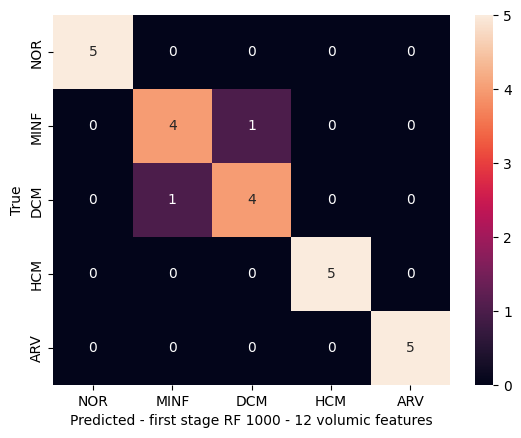 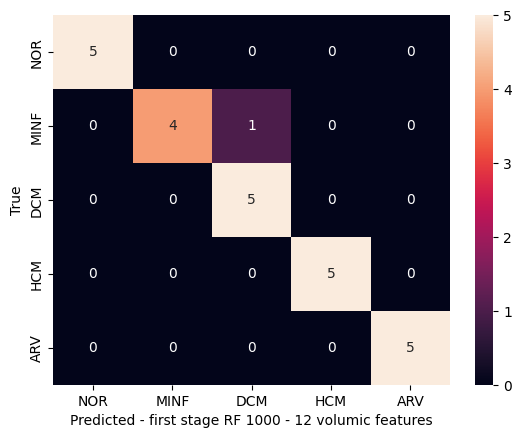

This architecture did not solve the NOR/HCM confusion (by design), but it did solve the DCM/MINF partly.

#### 7.2.2 - Single-stage classifier with thicknesses

Trying different coherent feature association and models, I managed to get a (94%, 93%, 94% joint accuracy) with a single-stage architecture using the thicknesses and the volumic features.

Surprisingly enough, a Naïve Gaussian Bayes classifier (sklearn implementation) did the trick. This is what really got to convince me that features are everything for this kind of task, the model is so simple and yet it performs so well.

Implementation is found in the GNBKaggle file (that was my chosen submission).

Features that led to this result are:

- Volume of the right ventricle in diastole and systole,

- Volume of the myocardium in diastole,

- Volume of the left ventricle in diastole and systole,

- Ratio of the left ventricle volume in systole over the right ventricle volume in systole,

- Ratio of the left ventricle volume in diastole over the right ventricle volume in diastole,

- Ratio of the left ventricle volume in systole over the myocardium volume in systole,

- Ratio of the left ventricle volume in diastole over the myocardium volume in diastole,

- Ejection fraction of the right ventricle,

- Maximum thickness of the myocardium across slices at systole,

- Mean thickness of the myocardium across slices at systole,

- Maximum thickness of the myocardium across slices at diastole,

- Mean thickness of the myocardium across slices at diastole.

which is a total of 12 features.

These features were found on the basis of all the discrimination found in [1] for the different pathologies. At first, I introduced all that could have some information on this discrimination rules, and I gradually removed the least informative features using sklearn feature_importance attritute. The goal was to reduce overfitting by only keeping the most informative discriminative features.

I then stopped when the validation accuracy decreased by the removal of a new feature.

I did that for several models and had the best result with a Gaussian Naïve Bayes classifier as mentioned.

Here is a typical confusion matrix associated with that approach:

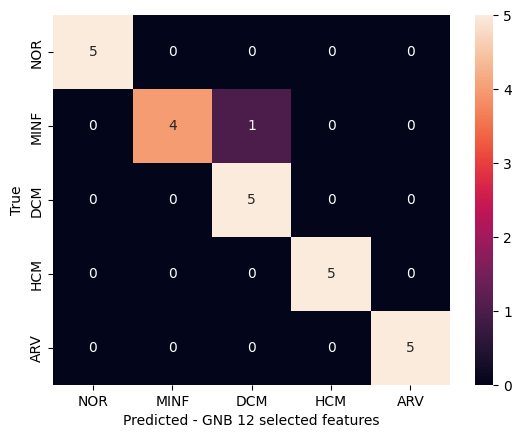

Seeing that a recurrent mistake was once again that DCM/MINF confusion, I did try to add a second stage but I saw no improvement.

## Conclusion

That pretty much ended my work on the challenge, I still had ideas to improve the model but I became a bit tired to be 100% honest as I spent a lot of time on it and it did not engage me as much as at the begining.

Ideas include: 

- improving second stage by using a MLP and finding the best informative features at that stage,

- finalizing my CNN architecture, 

- trying a third stage on the NOR/HCM confusion,

- extracting geometric features,

- ...

I overall enjoyed the challenge a lot and I learnt so so so much like I cannot stress that enough and I am thankful for that.

Sources:

[1] : Discrimination rules and ideas https://ieeexplore.ieee.org/document/8360453

[2] : The paper that gave me the idea for a second stage expert (first result when typing "cardiac two stage classification" on google scholar) https://ieeexplore.ieee.org/abstract/document/871404?casa_token=yzjToNcgpRkAAAAA:pP7HEWi_4krFCNpZFdHlSqAsIq2qVyNCULw38M5ygz-Q-DA8Cp_3gZWX4zKxmjdxW1bKpIi6

Wikipedia pages:
MINF : https://en.wikipedia.org/wiki/Myocardial_infarction

DCM : https://en.wikipedia.org/wiki/Dilated_cardiomyopathy

HCM : https://en.wikipedia.org/wiki/Hypertrophic_cardiomyopathy

ARV : https://en.wikipedia.org/wiki/Right_ventricular_hypertrophy